# 2D 2 comp GMM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
from scipy.stats import norm
import corner as corner

In [2]:
%matplotlib notebook

<IPython.core.display.Javascript object>


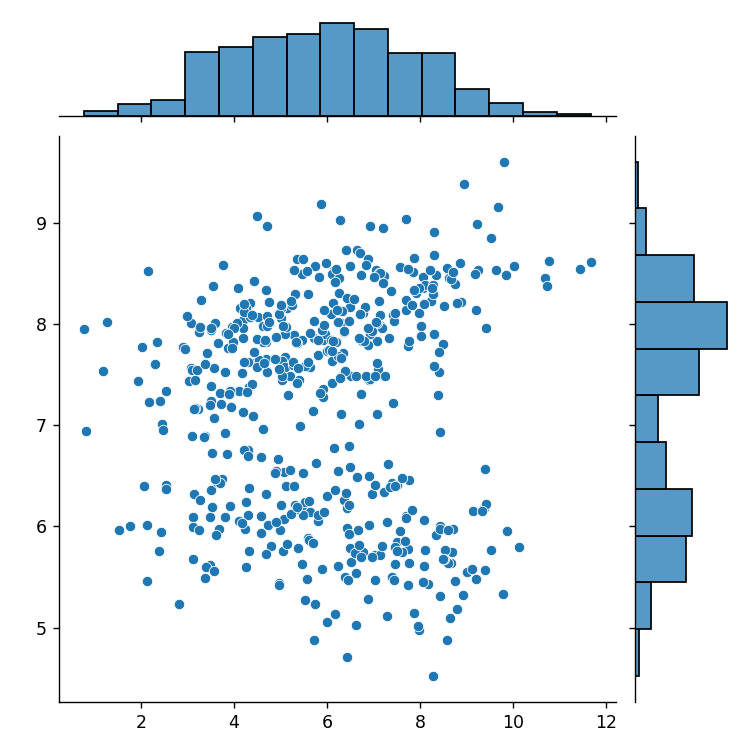

In [3]:
#Sets the seed
set_seed = True
if set_seed:
    np.random.seed(923114)

#Creates a covariance matrix with given standard deviations and correlation
def CorrToCov(σ, corr):
    R = np.matrix([[1, corr], [corr, 1]])
    D = np.matrix(np.diag(σ))
    S = D*R*D.T
    return S

#Generating the data for the first component
N0 = 300
μ0 = [6, 8]
σ0 = [2, 0.5]
corr0 = 0.5
Σ0 = CorrToCov(σ0, corr0)
data0 = multivariate_normal.rvs(size=N0, mean=μ0, cov=Σ0)

#Similarly for the second component
N1 = 200
μ1 = [6, 6]
σ1 = [2, 0.5]
corr1 = -0.3
Σ1 = CorrToCov(σ1, corr1)
data1 = multivariate_normal.rvs(size=N1, mean=μ1, cov=Σ1)

#Joining both components then plotting
data = np.vstack([data0, data1])
ax = sns.jointplot(x=data[:,0], y=data[:,1])

In [4]:
#Cholesky lower triangular matrix
def CholeskyLTM(lem):
    L = np.matrix([[np.exp(lem[0]), 0], [lem[1], np.exp(lem[2])]])
    Σ = L*L.T
    return Σ

#Esnuring the covariance matrix is positive semi-definite
def model(x, p):
    lem0 = p[2:5]
    Σ0 = CholeskyLTM(lem0)
    
    lem1 = p[7:10]
    Σ1 = CholeskyLTM(lem1)
    
    return p[:2], Σ0, p[5:7], Σ1, p[10]

#Defining the log likelihood
def log_likelihood(p, x, prior_check=1):
    μ0, Σ0, μ1, Σ1, weight = model(x, p)
    
    logl0 = multivariate_normal.logpdf(x, mean=μ0, cov=Σ0) * (1-weight)
    logl1 = multivariate_normal.logpdf(x, mean=μ1, cov=Σ1) * weight
    
    logl = np.logaddexp(logl0, logl1)
    
    return np.sum(logl)*prior_check

In [5]:
from dynesty import NestedSampler

ndim = 11

def unit_transform(u, centre, span):
    return 2*span*u + centre-span

def prior_transform(u):
    x = np.array(u)
    
    x[0] = norm.ppf(x[0], 6, 2)
    x[1] = norm.ppf(x[1], 8, 2)
    
    x[5] = norm.ppf(x[0], 6, 2)
    x[6] = norm.ppf(x[0], 6, 2)
    return x

sampler = NestedSampler(log_likelihood, prior_transform, ndim, logl_args=[data], nlive=2000)
sampler.run_nested()

z = sampler.results
results = z.samples_equal()

C:\Users\Iwan\AppData\Local\Temp\ipykernel_12252\1475410738.py:24: RuntimeWarning: invalid value encountered in logaddexp
  logl = np.logaddexp(logl0, logl1)


ValueError: The log-likelihood of live point is invalid.